In [44]:
using Plots; gr()
using LsqFit
using CUDA
using Statistics
using StatsBase
using Flux

global magneticPermeability = 1.256 * 10e-6
global solenoidLoopCount = 74
global solenoidRadius = 0.0058
global copperRadius = 0.00065
global solenoidLength = 2*π*solenoidRadius*solenoidLoopCount
global solenoidResistance = 1.68 * 10e-8 * solenoidLength
global copperDensity = 8850
global solenoidMass = solenoidLength * π * copperRadius^2 * copperDensity # 0.018
global magneticMoment = 0.4
global functionConst = (magneticMoment * magneticPermeability / 2)^2 * (12 * solenoidLoopCount * solenoidRadius) / (solenoidResistance * solenoidMass)
F(z) = functionConst * (2*z^3/(solenoidRadius^2 + z^2)^5 + z/(solenoidRadius^2 + z^2)^4)
display("Function constant is: $functionConst")

"Function constant is: 0.0022644979286338693"

In [12]:
solenoidMass

0.031678122823062024

In [4]:
posGen(initZ, gravitationalConst, timeInterval) = @. initZ - 1/2 * gravitationalConst * timeInterval ^ 2
veloGen(gravitationalConst, timeInterval) = @. - gravitationalConst * timeInterval
voltage(z, v) = @. - solenoidLoopCount * magneticPermeability * solenoidMass * z / 2 * v * (1/(solenoidRadius + z^2)^(3/2) - 3*z^2/(solenoidRadius^2 + z^2)^(5/2))

global simTime = 0.4
global timeStep = 0.001
global timeInterval = CuArray(collect(0:timeStep:simTime))

function voltSim(initZ, gravitationalConst)
	posVect = posGen(initZ, gravitationalConst, timeInterval)
	veloVect = veloGen(gravitationalConst, timeInterval)
	volVect = voltage(posVect, veloVect)
	minVol, maxVol = extrema(volVect)
	return maxVol - minVol
end

voltSim (generic function with 1 method)

In [114]:
data1 = [
	3.28 3.04 3.44 4.08 3.12;
	3.36 3.28 3.76 4.48 4.40;
	4.64 4.96 4.88 4.72 4.72;
	5.44 5.36 5.04 5.76 5.44;
	6.72 6.08 6.16 6.72 6.69
]
meanData1 = mean(data1, dims = 2)
dataPos1 = collect(0:0.01:0.04)

data2 = [
	106 112 118 112 114;
	136 130 148 148 144;
	162 168 164 172 162;
	190 212 182 188 194;
	222 224 218 238 234;
	236 232 236 234 242;
	248 250 276 244 256;
	288 278 262 290 290
] / 1000
meanData2 = mean(data2, dims = 2)
dataPos2 = collect(0:0.02:0.14)

normDat = (data2 .- minimum(data2)) * 4.45 .+ minimum(data2)
normDatMean = (meanData2 .- minimum(meanData2)) * 4.45 .+ minimum(meanData2) # 4.5 for 9.74

default(fontfamily = "Helvetica")
plot(dataPos2, normDatMean, label = "Mean", linewidth = 3, color =:black, xlabel = "Initial magnet height", ylabel = "Pk-Pk Voltage difference", xtick = collect(0:0.02:0.14), size = (400, 300))
plot!(dataPos2, normDat, label = ["Trial 1" "Trial 2" "Trial 3" "Trial 4" "Trial 5"])
savefig("raw-data.svg")

"/home/puripat/Documents/Workspace/ElectricGravityExperiment/code/raw-data.svg"

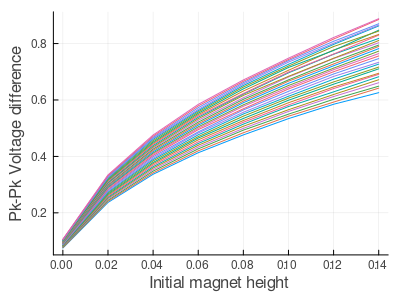

In [150]:
gVect = collect(6:0.2:12)
zVect = collect(0:0.02:0.14)
gMat = gVect * ones(size(zVect, 1))'
zMat = ones(size(gMat, 1)) * zVect'

voltMat = voltSim.(zMat, gMat)

plot(dataPos2, voltMat', legends = false, size = (400, 300), xlabel = "Initial magnet height", ylabel = "Pk-Pk Voltage difference", xtick = collect(0:0.02:0.14), linewidth = 1) # Default: linewidth = 0.3
# plot!(dataPos2, voltMat'[:, 20], color =:blue, linewidth = 3)
# plot!(dataPos2, normDatMean, color =:black, linewidth = 3)
# savefig("theoretical-pk-pk.svg")

In [147]:
# Calculating errors
errorVect = []
rSqVect = []
function rSquared(y, ypred)
	ss_res = sum((y .- ypred).^2)
	ss_tot = sum((y .- mean(y)).^2)
	return 1 - ss_res/ss_tot
end
for i in 1:size(gVect, 1)
	push!(errorVect, Flux.Losses.mse(normDatMean, voltMat'[:, i]))
	push!(rSqVect, rSquared(normDat, voltMat'[:, i]))
end
display(gVect[findall(x -> x == minimum(errorVect), errorVect)])
display(rSqVect[findall(x -> x == minimum(errorVect), errorVect)])
plot(gVect, [errorVect], legends = false, ylabel = "Mean squared error", xlabel = "Gravitational acceleration", size = (400, 300))
scatter!([gVect[findall(x -> x == minimum(errorVect), errorVect)]], [minimum(errorVect)], color = :blue)
savefig("mse-gravity.svg")

1-element Vector{Float64}:
 9.529

1-element Vector{Any}:
 0.9423768024689663

"/home/puripat/Documents/Workspace/ElectricGravityExperiment/code/mse-gravity.svg"